In [216]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from algorithms.snn import SNN
from sklearn.metrics import r2_score
import time
from synthetic_data_generation.generate_eval import sales_data_staggering_assignment, sales_data_si_assignment, sales_data_random_assignment
from sklearn.cluster import SpectralBiclustering

In [217]:
datasets_generators = [sales_data_si_assignment, sales_data_staggering_assignment, sales_data_random_assignment]



array([[[[61933.46926557],
         [63216.12226136],
         [32116.87632914]],

        [[64359.81722361],
         [64243.71485683],
         [31367.50577613]],

        [[46030.90753168],
         [44183.51251665],
         [28968.84817329]],

        ...,

        [[39251.55320797],
         [39022.12779664],
         [29561.68672783]],

        [[40515.91068504],
         [41696.96663302],
         [30573.26564437]],

        [[68905.85631478],
         [71866.09249299],
         [33697.15028048]]],


       [[[62654.52795473],
         [63942.03357791],
         [32169.78323042]],

        [[65363.57241235],
         [65638.75363435],
         [31693.16292575]],

        [[45249.84639065],
         [43824.74235213],
         [29191.73961157]],

        ...,

        [[37745.93497759],
         [37408.5069128 ],
         [29387.07270806]],

        [[39096.59356048],
         [39857.78986339],
         [30200.22210233]],

        [[70276.80621726],
         [72985.6478904 ],
   

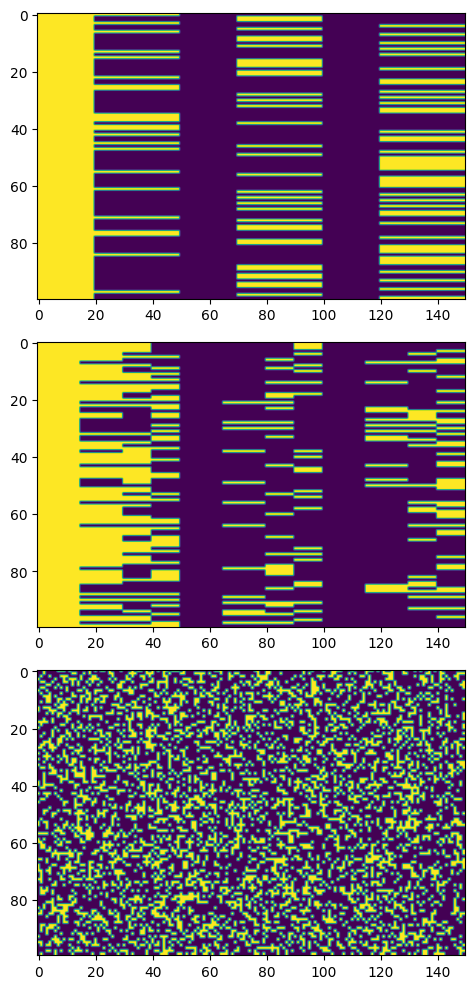

In [669]:
data = {}
masks = {}
observed_matrix = {}
full_matrix = {}
fig, axes = plt.subplots(3,1, figsize = (6,10))
for k, data_gen in enumerate(datasets_generators[:]):
    data[k] = data_gen()
    masks[k] = data[k].mask.reshape([-1,3*50], order = "F")
    full_matrix[k] = data[k].tensor.reshape([-1,3*50], order = "F")
    observed_matrix[k] = np.array(full_matrix[k])
    observed_matrix[k][masks[k]==0] = np.nan
    axes[k].imshow(masks[k][:,:])
plt.tight_layout()

In [747]:
model = SpectralBiclustering(n_clusters=(3,5), n_best = 5, n_components = 6, method = "log",    random_state=0)
model.fit(masks[2])
fit_data = masks[2][np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]



In [748]:
mask[0].shape


(150,)

In [749]:
clusters = np.zeros_like(fit_data)
clusters[:,:] = model.row_labels_.reshape(-1,1)
clusters[:,:] += 100* model.column_labels_.reshape(1,-1)
clusters = clusters[np.argsort(model.row_labels_)]
clusters = clusters[:, np.argsort(model.column_labels_)]
clusters_dict = dict(zip(np.unique(clusters), np.arange(len(np.unique(clusters))) ))
clusters = np.vectorize(clusters_dict.get)(clusters)


In [750]:
model.row_labels_

array([0, 0, 2, 0, 0, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0,
       1, 0, 2, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 0, 1, 1, 2,
       2, 1, 2, 2, 0, 0, 1, 0, 2, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 2,
       2, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2], dtype=int32)

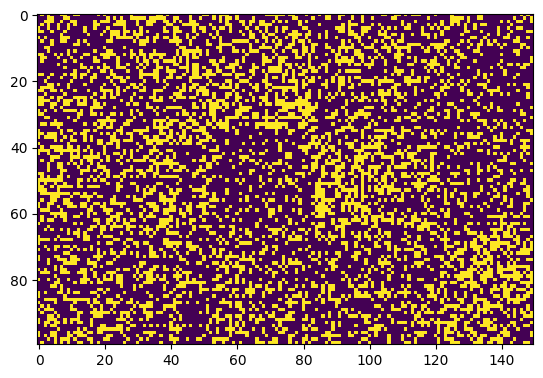

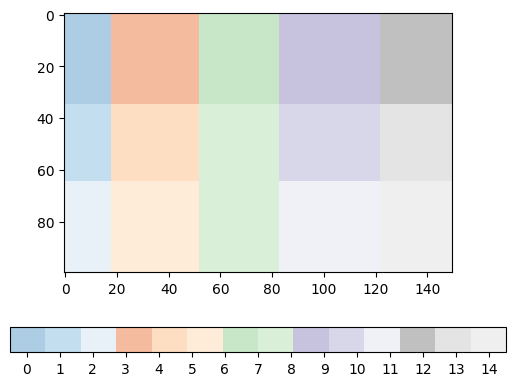

In [751]:
import matplotlib
plt.imshow(fit_data)
cmap = matplotlib.cm.get_cmap('tab20c', clusters.max())
plt.figure()
im = plt.imshow(clusters, cmap=cmap, vmin = -0.5, vmax = clusters.max()+.5, interpolation="none",  aspect=1, alpha = 0.4)
fig.colorbar(im, ticks=range(100), orientation="horizontal")
# plt.imshow(clusters, alpha = 0.4,)

In [1165]:
def pcr_ALS(X, y, max_rank = None, spectral_t = None, min_singular_value = 1e-7 ):
    """
    principal component regression (PCR)
    """
    X_copy = np.array(X)
    X_copy[np.isnan(X_copy)] = 0
    p = 1- np.isnan(X_copy).sum()/X_copy.size
    (u, s, v) = np.linalg.svd(X_copy/p, full_matrices=False)
    if max_rank is not None:
        rank = max_rank
    elif spectral_t is not None:
        rank = _spectral_rank(s, spectral_t)
    else:
        (m, n) = X.shape
        rank = universal_rank(s, ratio=m / n)
    
  
    weights, factors = parafac(X_copy, rank=rank, mask = ~np.isnan(X), init = "random")
    X_als = factors[0]@factors[1].T
    beta = np.linalg.lstsq(X_als, y, rcond= 1e-4)[0]
    u_rank = factors[0]
    v_rank = factors[1]
    s_rank = weights
    
    return (beta, u_rank, s_rank, v_rank)


def get_beta(X, missing_row, anchor_rows, anchor_cols):
    y1 = X[missing_row, anchor_cols]
    X1 = X[anchor_rows, :]
    X1 = X1[:, anchor_cols]
    (beta, _, s_rank, v_rank) = pcr_ALS(X1.T, y1)
    return beta, v_rank

def _spectral_rank( s, spectral_t):
    """
    retain all singular values that compose at least (100*self.spectral_t)% spectral energy
    """
    if spectral_t == 1.0:
        rank = len(s)
    else:
        total_energy = (s**2).cumsum() / (s**2).sum()
        rank = list((total_energy > spectral_t)).index(True) + 1
    return rank

def universal_rank( s, ratio):
    """
    retain all singular values above optimal threshold as per Donoho & Gavish '14:
    https://arxiv.org/pdf/1305.5870.pdf
    """
    omega = 0.56 * ratio**3 - 0.95 * ratio**2 + 1.43 + 1.82 * ratio
    t = omega * np.median(s)
    rank = max(len(s[s > t]), 1)
    return rank

def pcr(X, y, max_rank = None, spectral_t = None, min_singular_value = 1e-7 ):
    """
    principal component regression (PCR)
    """
    X[np.isnan(X)] = 0
    p = 1- np.isnan(X).sum()/X.size
    (u, s, v) = np.linalg.svd(X/p, full_matrices=False)
    if max_rank is not None:
        rank = max_rank
    elif spectral_t is not None:
        rank = _spectral_rank(s, spectral_t)
    else:
        (m, n) = X.shape
        rank = universal_rank(s, ratio=m / n)
    s_rank = s[:rank]
    u_rank = u[:, :rank]
    v_rank = v[:rank, :]
    
    # filter out small singular values
    k = np.argmin(s_rank < min_singular_value)+1
    s_rank = s[:k]
    u_rank = u[:, :k]
    v_rank = v[:k, :]

    beta = ((v_rank.T / s_rank) @ u_rank.T) @ y
    return (beta, u_rank, s_rank, v_rank)


def synth_neighbor(X, missing_pair, anchor_rows, anchor_cols):
    """
    construct the k-th synthetic neighbor
    """
    # initialize
    (missing_row, missing_col) = missing_pair
    X2 = X[anchor_rows, missing_col]

    beta, v_rank = get_beta(
        X, missing_row, anchor_rows, anchor_cols
    )
    # prediction
    pred = X2 @ beta

    return pred

def get_factors(X, cluster):
    cluster_rows = cluster["rows"]
    cluster_cols = cluster["cols"]
    cluster["rows_dict"] = dict(zip(cluster_rows, np.arange(len(cluster_rows))))
    cluster["cols_dict"] = dict(zip(cluster_cols, np.arange(len(cluster_cols))))
    X1 = X[cluster_rows, :]
    X1 = X1[:, cluster_cols]
    (u_rank, s_rank, v_rank) = compute_factors(X1, cluster)
    cluster["u_rank"] = u_rank
    cluster["v_rank"] = v_rank
    cluster["s_rank"] = s_rank
    return cluster


def compute_factors(X, cluster, max_rank = None,spectral_t = None, min_singular_value = 1e-7 ):
    """
    principal component regression (PCR)
    """
    X_copy = np.array(X)
    X_copy[np.isnan(X_copy)] = 0
    p = 1- np.isnan(X_copy).sum()/X_copy.size
    (u, s, v) = np.linalg.svd(X_copy/p, full_matrices=False)
    if max_rank is not None:
        rank = max_rank
    elif spectral_t is not None:
        rank = _spectral_rank(s, spectral_t)
    else:
        (m, n) = X.shape
        rank = universal_rank(s, ratio=m / n)
    rank = min(np.sum(s > min_singular_value), rank)
    weights, factors = parafac(X_copy, rank=rank, mask = ~np.isnan(X), init = "random")
    u_rank = factors[0]
    v_rank = factors[1]
    s_rank = weights
    return u_rank, s_rank, v_rank
    
def get_beta_from_factors(X, missing_row, anchor_rows, anchor_cols, cluster):
    u_rank = cluster["u_rank"]
    v_rank = cluster["v_rank"]
    y1 = X[missing_row, anchor_cols]
    rows = np.vectorize(cluster["rows_dict"].get, )(anchor_rows)
    cols = np.vectorize(cluster["cols_dict"].get, )(anchor_cols)
    X_als = u_rank[rows,:]@v_rank[cols,:].T
    beta = np.linalg.lstsq(X_als.T, y1, rcond= 1e-4)[0]
    return beta
    

def synth_neighbor2(X, missing_pair, anchor_rows, anchor_cols, cluster):
    """
    construct the k-th synthetic neighbor
    """
    # check if factors is already computed
    (missing_row, missing_col) = missing_pair
    
    if "u_rank" not in cluster:
        cluster = get_factors(X, cluster)
    
    beta = get_beta_from_factors(X, missing_row, anchor_rows, anchor_cols, cluster)
    
    X2 = X[anchor_rows, missing_col]
    # prediction
    pred = X2 @ beta

    return pred

In [1166]:
from tqdm import tqdm

In [1241]:

data_index = 2
# find clusters
clusters = {}; index = 0
for idx in range(5):
    model = SpectralBiclustering(n_clusters=(4+idx,4+idx), n_best = 6, n_components = 7, method = "log",    random_state=6*idx)
    model.fit(masks[data_index])

    ## process clusters
    row_clusters = np.unique(model.row_labels_)
    col_clusters = np.unique(model.column_labels_)
    # loop over clusters
    for row_clus in row_clusters:
        for col_clus in col_clusters:
            rows = np.where(model.row_labels_ == row_clus)[0]
            cols = np.where(model.column_labels_ == col_clus)[0]
            cluster = np.array(masks[data_index][rows,:][:,cols])
            if cluster.mean()< 0.2: continue
            
            # remove columns and then rows that are mostly nans
            col_avges = cluster.mean(0)
            retained_cols = col_avges > 0.5
            retained_cols_index = cols[retained_cols]
            cluster = cluster[:,retained_cols]
            if cluster.shape[0] == 0 or cluster.shape[1] == 0:
                continue
            
            row_avges = cluster.mean(1)
            retained_rows = row_avges > 0.5
            retained_rows_index = rows[retained_rows]
            cluster = cluster[retained_rows,:]
            
            # check sparsity, if more than 60% drop
            if cluster.mean()< 0.5: continue
            
            # retain cols and rows and data
            clusters[index] = {"rows": retained_rows_index,
            "cols": retained_cols_index,
            "data": observed_matrix[data_index][retained_rows_index,:][:,retained_cols_index], 
            "sparsity": 1- masks[data_index][retained_rows_index,:][:,retained_cols_index].mean()
            }
            index+=1
            
print(f"Generated {index} clusters")  
X = np.array(observed_matrix[data_index])
X_filled = np.array(observed_matrix[data_index])
num_clusters = 3
    
X_filled_estimates = np.full([X.shape[0], X.shape[1], num_clusters], np.nan)
X_filled_estimates[~np.isnan(X), 0] = X[~np.isnan(X)]
missing_set = np.argwhere(np.isnan(X))
num_missing = len(missing_set)
clusters_row_matrix = np.zeros([len(clusters), X.shape[0]])
for i, cl in enumerate(clusters.values()):
    clusters_row_matrix[i, cl["rows"]] = 1
clusters_col_matrix = np.zeros([len(clusters), X.shape[1]])
for i, cl in enumerate(clusters.values()):
    clusters_col_matrix[i, cl["cols"]] = 1


# loop over missing values
for (k, missing_pair) in tqdm(enumerate(missing_set)):
    i,j  = missing_pair
    obs_rows = np.argwhere(~np.isnan(X[:, j])).flatten()
    obs_cols = np.argwhere(~np.isnan(X[i, :])).flatten()
    if len(obs_rows) < 1 or len(obs_cols) < 1: continue
    # construct row vector
    obs_rows_vector = np.zeros(X.shape[0])
    obs_rows_vector[obs_rows] = 1
    obs_cols_vector = np.zeros(X.shape[1])
    obs_cols_vector[obs_cols] = 1

    # multiply by cluster_row_matrix and clusters_col_matrix
    clusters_row_matching = clusters_row_matrix @ obs_rows_vector 
    clusters_col_matching = clusters_col_matrix @ obs_cols_vector 
    
    # select based on max
    selected_cluster = np.argsort(clusters_row_matching*clusters_col_matching)[-num_clusters:]
    
    if max(clusters_row_matching*clusters_col_matching) < 9: continue
    pred = 0
    counter =0
    for clus in selected_cluster:
        # get minimal anchor rows and cols
        rows_cluster = clusters_row_matrix[clus,:]
        cols_cluster = clusters_col_matrix[clus,:]
        anchor_rows = np.where(obs_rows_vector * rows_cluster)[0]
        anchor_cols = np.where(obs_cols_vector * cols_cluster)[0]
        
        cluster = np.array(masks[data_index][anchor_rows,:][:,anchor_cols])
        if not cluster.any(): continue

        if  cluster.sum(0).min() < 2 or cluster.mean(1).sum() < 2 or cluster.mean()<0.3 : 
            continue

        prediction = synth_neighbor2(X, missing_pair, anchor_rows, anchor_cols, clusters[clus])
        #synth_neighbor(
                    #     X,
                    #     missing_pair=missing_pair,
                    #     anchor_rows=anchor_rows,
                    #     anchor_cols=anchor_cols,
                    # )
        X_filled_estimates[i,j, counter] = prediction

        counter +=1
    if counter> 0:
        X_filled[i,j] = np.nanmean(X_filled_estimates[i,j, :])

Generated 157 clusters


10000it [00:12, 830.91it/s]


(0.8070222026152558, 8031.99399852464, 0.809659573342491)

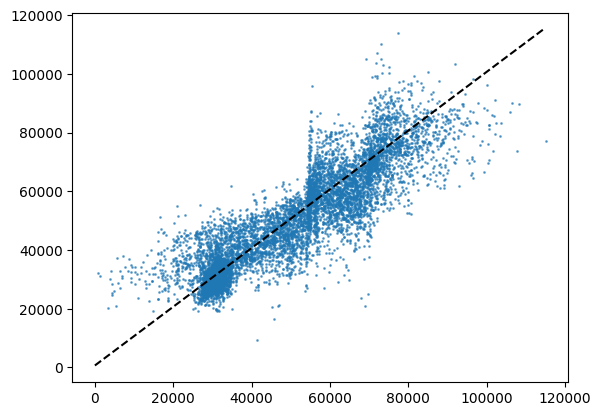

In [1242]:
truth = full_matrix[data_index]
notnan = ~np.isnan(X_filled)
mask = masks[data_index]
r2 =  r2_score(truth[notnan][mask[notnan] == 0].flatten(), X_filled[notnan][mask[notnan] == 0].flatten())
mse = np.nanmean(np.square(truth[:][mask[:]==0].flatten() - X_filled[:][mask[:] == 0].flatten()))
truth_ = truth[mask ==0].flatten()
estimate = X_filled[mask == 0].flatten()
plt.scatter(truth_[np.abs(estimate)< 1e6], estimate[np.abs(estimate)< 1e6], s = 1, alpha = 0.6)
plt.plot(np.arange(truth.min(), truth.max()), 'k--')
r2, np.sqrt(mse), r2_score(truth_[np.abs(estimate)< 1e5], estimate[np.abs(estimate)< 1e5])

In [1243]:
np.isnan(X_filled).sum()

106

### ALS instead of SVT

In [808]:
import tensorly as tl
from tensorly.decomposition import parafac


In [995]:
N = 10
M = 10
k = 2
U = np.random.random([N, k])
V = 2* np.random.random([M, k]) 
A = U@V.T
A_obs = np.array(A)
A_obs[np.random.random(A.shape) < 0.1] =  np.nan
A_f = np.array(A_obs)
A_f[np.isnan(A_obs)]= 0
err1 = 0
err2 = 0
for _ in range(10):
    factors = parafac(A_f, rank=2, mask = ~np.isnan(A_obs), init = "svd")
    A_hat = factors.factors[0]@factors.factors[1].T
    err1 += np.abs(A-A_hat).mean()
    factors = parafac(A_f, rank=2, mask = ~np.isnan(A_obs), init = "random")
    A_hat = factors.factors[0]@factors.factors[1].T
    err2 += np.abs(A-A_hat).mean()

In [996]:
print(err1, err2)

0.32936052561544094 2.3769286597585813e-07


In [838]:
factors[1]

[array([[-1.48887281,  0.24813796],
        [-0.93423286,  0.16549529],
        [-2.23199005,  0.12858004],
        [-2.54610148,  0.09032811],
        [-2.21858399, -0.09867103],
        [-0.81499578, -0.16586976],
        [-0.83751632, -0.01784037],
        [-0.99998041, -0.00798205],
        [-1.88133943, -0.35294763]]),
 array([[-0.21631283, -0.20990809],
        [-0.30365055,  0.16702342],
        [-0.34013125, -0.55463427],
        [-0.16664376,  0.40053364],
        [-0.40037544,  0.14937584],
        [-0.13894542,  0.42033675],
        [-0.31244902,  0.18497129],
        [-0.35278647, -0.32873848],
        [-0.50458077, -0.05475953],
        [-0.24749736,  0.34017247]])]